In [2]:
from itertools import product
import sys

import numpy as np
from scipy import sparse
from scipy.sparse import eye as speye
from scipy.sparse.linalg import cg

from matplotlib import pyplot as plt, cm, colors

import networkx as nx

sys.path.append('../src')

from algraph import GraphThresholdActiveLearner
from parallel import GridParallel

In [3]:
class BernoulliSampler(object):
    
    def __init__(self, ps):
        self.ps = ps
        self.N = self.ps.size
    
    def __call__(self, i):
        return 1 if np.random.rand() < self.ps[i] else 0

class GaussianSampler(object):
    
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.N = self.mu.size
    
    def __call__(self, i):
        return self.mu[i] + np.random.randn() * self.sigma

def apply_APT(sampler, T, tau, epsilon):
    
    # initialize with two samples at all arms
    mu_cur = np.array([(sampler(i) + sampler(i)) / 2 for i in range(sampler.N)])
    ns = np.ones(sampler.N) * 2
    
    # apply APT
    mu_hats = np.zeros((T, sampler.N))
    for t in range(T):
        
        i = np.argmin(np.sqrt(ns) * (np.abs(mu_cur - tau) + epsilon))        
        mu_cur[i] = (mu_cur[i] * ns[i] + sampler(i)) / (ns[i] + 1)
        ns[i] += 1
        mu_hats[t, :] = mu_cur.copy()
        
    return mu_hats

def apply_GraphAPL(sampler, T, graph, tau, gamma, epsilon, alpha=1e-8, verbose=True):
    
    gapl = GraphThresholdActiveLearner(graph, tau, gamma, epsilon=epsilon, alpha=alpha)
    
    mu_hats = np.zeros((T, sampler.N))
    
    for t in range(T):
        
        if verbose:
            if (t > 0 and t % 1000 == 0) or t == T - 1:
                print('')
            if t % 10 == 0:
                print('.', end='')
        
        i = gapl.get_next_location()
        gapl.update(i, sampler(i))
        mu_hats[t, :] = gapl.mu_hat.copy()
    
    return mu_hats

def apply_random_sampling_with_laplacian(sampler, T, graph, tau, gamma, epsilon, alpha=1e-8, verbose=True):
    
    gapl = GraphThresholdActiveLearner(graph, tau, gamma, epsilon=epsilon, alpha=alpha)
    
    mu_hats = np.zeros((T, sampler.N))
    
    for t in range(T):
        
        if verbose:
            if (t > 0 and t % 1000 == 0) or t == T - 1:
                print('')
            if t % 10 == 0:
                print('.', end='')
        
        i = np.random.choice(sampler.N)
        gapl.update(i, sampler(i))
        mu_hats[t, :] = gapl.mu_hat.copy()
    
    return mu_hats

def failure_rate(mu, mu_hats, tau, epsilon):
    check_mask = (np.abs(mu - tau) > epsilon)
    return 1 - np.sum(((mu_hats[:, check_mask] - tau) * (mu[check_mask] - tau)[None, :]) > 0, 1) / mu.size

In [ ]:
def run_small_world_bernoulli(n, m, p, lamda_gen, T, gamma, tau=0.5, epsilon=0.1, verbose=True):
    
    try:
        graph = nx.connected_watts_strogatz_graph(n, m, p)
    except Exception as e:
        print('Failed to generate connected Watts-Strogatz graph.')
        return None
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate random smooth signal and clip to [0, 1]
    mu, info = cg(L + speye(n) / lamda_gen / n, np.random.randn(n))
    mu -= np.median(mu)
    mu /= np.std(mu) * 5
    mu += 0.5
    mu = np.clip(mu, 0, 1)
    mu = np.clip(mu, 0, 1)
    
    sampler = BernoulliSampler(mu)
    #sampler = GaussianSampler(mu, 1)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_GraphAPL(sampler, T, graph, tau, gamma, epsilon, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [ ]:
def run_small_world_bernoulli_random_laplacian(n, m, p, lamda_gen, T, gamma, tau=0.5, epsilon=0.1, verbose=True):
    
    try:
        graph = nx.connected_watts_strogatz_graph(n, m, p)
    except Exception as e:
        print('Failed to generate connected Watts-Strogatz graph.')
        return None
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate random smooth signal and clip to [0, 1]
    mu, info = cg(L + speye(n) / lamda_gen / n, np.random.randn(n))
    mu -= np.median(mu)
    mu /= np.std(mu) * 5
    mu += 0.5
    mu = np.clip(mu, 0, 1)
    mu = np.clip(mu, 0, 1)
    
    sampler = BernoulliSampler(mu)
    #sampler = GaussianSampler(mu, 1)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_random_sampling_with_laplacian(sampler, T, graph, tau, gamma, epsilon, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [ ]:
n = 10**3
m = 3
p = 0.2
lamda_gen = 1000
T = 5000
gammas = [0.1, 1, 10, 100, 1000]
tau = 0.5
epsilon = 1e-2

n_trials = 100

res = GridParallel(n_jobs=7, verbose=1)(run_small_world_bernoulli, n_trials*[n], [m], [p], [lamda_gen], [T], gammas, [tau], [epsilon], [False])
res_np = np.squeeze(res)
res_rand = GridParallel(n_jobs=7, verbose=1)(run_small_world_bernoulli_random_laplacian, n_trials*[n], [m], [p], [lamda_gen], [T], gammas, [tau], [epsilon], [False])
res_rand_np = np.squeeze(res_rand)

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 5), dpi=200)
for i in [gammas.index(g) for g in [0.1, 1, 10, 100, 1000]]:
    y = np.median(res_np[:, i, 0, :], 0)
    y_1q = np.percentile(res_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res_np[:, i, 0, :], 75, 0)
    plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, c=colors[i], label='gamma=%g' % gammas[i])
    y = np.median(res_rand_np[:, i, 0, :], 0)
    y_1q = np.percentile(res_rand_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res_rand_np[:, i, 0, :], 75, 0)
    plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, ':', c=colors[i], label='gamma=100 random')
y = np.median(res_np[:, 0, 1, :], 0)
y_1q = np.percentile(res_np[:, 0, 1, :], 25, 0)
y_3q = np.percentile(res_np[:, 0, 1, :], 75, 0)
plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='black', alpha=0.4)
plt.plot(y, c='black', label='APT')
plt.legend()
plt.ylim(0, 0.6)
plt.show()

In [ ]:
np.savez('small_world_5000.npz', res_np=res_np, res_rand_np=res_rand_np)

In [19]:
def run_newman_small_world_bernoulli(n, m, p, lamda_gen, T, gamma, tau=0.5, epsilon=0.1, alpha=1e-8, verbose=True):
    
    graph = nx.newman_watts_strogatz_graph(n, m, p)
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate random smooth signal and clip to [0, 1]
    mu, info = cg(L + speye(n) / lamda_gen / n, np.random.randn(n))
    mu -= np.median(mu)
    mu /= np.std(mu) * 5
    mu += 0.5
    mu = np.clip(mu, 0, 1)
    
    sampler = BernoulliSampler(mu)
    #sampler = GaussianSampler(mu, 1)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_GraphAPL(sampler, T, graph, tau, gamma, epsilon, alpha=alpha, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [20]:
def run_newman_small_world_bernoulli_random_laplacian(n, m, p, lamda_gen, T, gamma, tau=0.5, epsilon=0.1, alpha=1e-8, verbose=True):
    
    graph = nx.newman_watts_strogatz_graph(n, m, p)
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate random smooth signal and clip to [0, 1]
    mu, info = cg(L + speye(n) / lamda_gen / n, np.random.randn(n))
    mu -= np.median(mu)
    mu /= np.std(mu) * 5
    mu += 0.5
    mu = np.clip(mu, 0, 1)
    
    sampler = BernoulliSampler(mu)
    #sampler = GaussianSampler(mu, 1)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_random_sampling_with_laplacian(sampler, T, graph, tau, gamma, epsilon, alpha=alpha, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [26]:
n = 10**3
m = 4
p = 0.01
lamda_gen = 1000
T = 5000
gammas = [0.1, 10, 1000]
tau = 0.5
epsilon = 1e-2
alpha = 1e-8

n_trials = 100

res2 = GridParallel(n_jobs=7, verbose=1)(run_newman_small_world_bernoulli, n_trials*[n], [m], [p], [lamda_gen], [T], gammas, [tau], [epsilon], [alpha], [False])
res2_np = np.squeeze(res2)
res2_rand = GridParallel(n_jobs=7, verbose=1)(run_newman_small_world_bernoulli_random_laplacian, n_trials*[n], [m], [p], [lamda_gen], [T], gammas, [tau], [epsilon], [alpha], [False])
res2_rand_np = np.squeeze(res2_rand)

Number of tasks: 300.


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed: 10.4min


Number of tasks: 300.


[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed: 17.1min finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed: 10.3min
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed: 16.5min finished


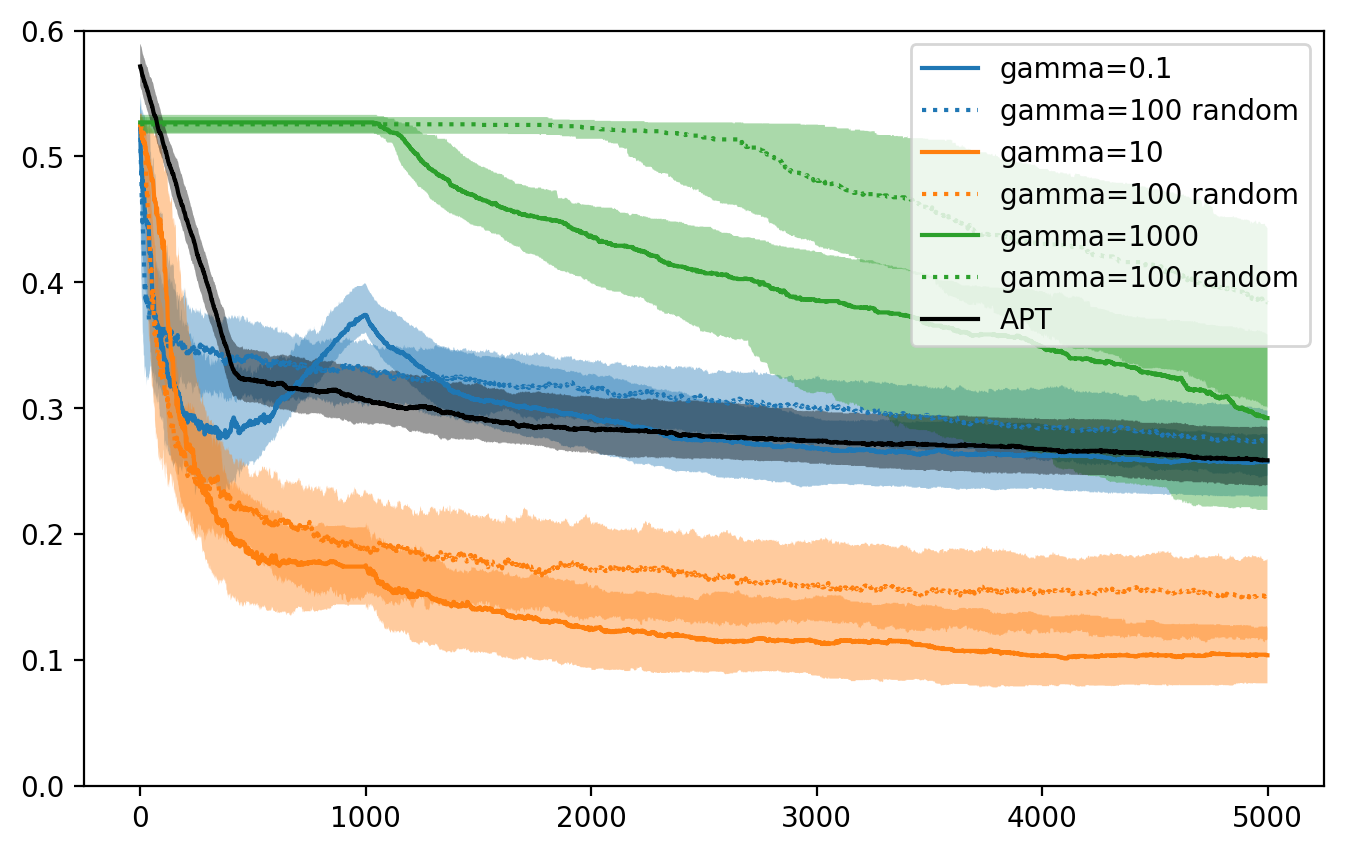

In [27]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 5), dpi=200)
for i in [gammas.index(g) for g in [0.1, 10, 1000]]:
    y = np.median(res2_np[:, i, 0, :], 0)
    y_1q = np.percentile(res2_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res2_np[:, i, 0, :], 75, 0)
    plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, c=colors[i], label='gamma=%g' % gammas[i])
    y = np.median(res2_rand_np[:, i, 0, :], 0)
    y_1q = np.percentile(res2_rand_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res2_rand_np[:, i, 0, :], 75, 0)
    plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, ':', c=colors[i], label='gamma=100 random')
y = np.median(res2_np[:, 0, 1, :], 0)
y_1q = np.percentile(res2_np[:, 0, 1, :], 25, 0)
y_3q = np.percentile(res2_np[:, 0, 1, :], 75, 0)
plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='black', alpha=0.4)
plt.plot(y, c='black', label='APT')
plt.legend()
plt.ylim(0, 0.6)
plt.show()

In [28]:
np.savez('newman_small_world_5000.npz', res2_np=res2_np, res2_rand_np=res2_rand_np)

In [4]:
def run_sbm_binary(n, sigma, T, gamma, tau=0.5, epsilon=0.1, alpha=1e-8, verbose=True):
    
    p_inner = np.log(n // 2) / (n // 2)
    p_cross = p_inner / np.sqrt(n // 2)
    graph = nx.stochastic_block_model([n // 2, n - n // 2], [[p_inner, p_cross], [p_cross, p_inner]])
    #graph = max(nx.connected_component_subgraphs(graph), key=len)
    #n = len(graph)
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate smooth signal and clip to [0, 1]
    mu = np.ones(n)
    mu[n // 2:] = -1
    
    #sampler = BernoulliSampler(mu)
    sampler = GaussianSampler(mu, sigma)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_GraphAPL(sampler, T, graph, tau, gamma, epsilon, alpha=alpha, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [5]:
def run_sbm_binary_random_laplacian(n, sigma, T, gamma, tau=0.5, epsilon=0.1, alpha=1e-8, verbose=True):

    p_inner = np.log(n // 2) / (n // 2)
    p_cross = p_inner / np.sqrt(n // 2)
    graph = nx.stochastic_block_model([n // 2, n - n // 2], [[p_inner, p_cross], [p_cross, p_inner]])
    #graph = max(nx.connected_component_subgraphs(graph), key=len)
    #n = len(graph)
    
    L = nx.linalg.laplacian_matrix(graph)
    
    # generate class signal
    mu = np.ones(n)
    mu[n // 2:] = -1
    
    #sampler = BernoulliSampler(mu)
    sampler = GaussianSampler(mu, sigma)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_random_sampling_with_laplacian(sampler, T, graph, tau, gamma, epsilon, alpha=alpha, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

In [10]:
n = 10**3
sigma = 2
T = 5000
gammas = [0.1, 1, 10, 100, 1000]
tau = 0
epsilon = 1e-2
alpha = 0.5

n_trials = 100

res3 = GridParallel(n_jobs=7, verbose=1)(run_sbm_binary, n_trials*[n], [sigma], [T], gammas, [tau], [epsilon], [alpha], [False])
res3_np = np.squeeze(res3)
res3_rand = GridParallel(n_jobs=7, verbose=1)(run_sbm_binary_random_laplacian, n_trials*[n], [sigma], [T], gammas, [tau], [epsilon], [alpha], [False])
res3_rand_np = np.squeeze(res3_rand)

Number of tasks: 500.


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   56.5s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  5.1min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 11.9min


Number of tasks: 500.


[Parallel(n_jobs=7)]: Done 500 out of 500 | elapsed: 13.7min finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   58.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  4.9min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 11.4min
[Parallel(n_jobs=7)]: Done 500 out of 500 | elapsed: 13.1min finished


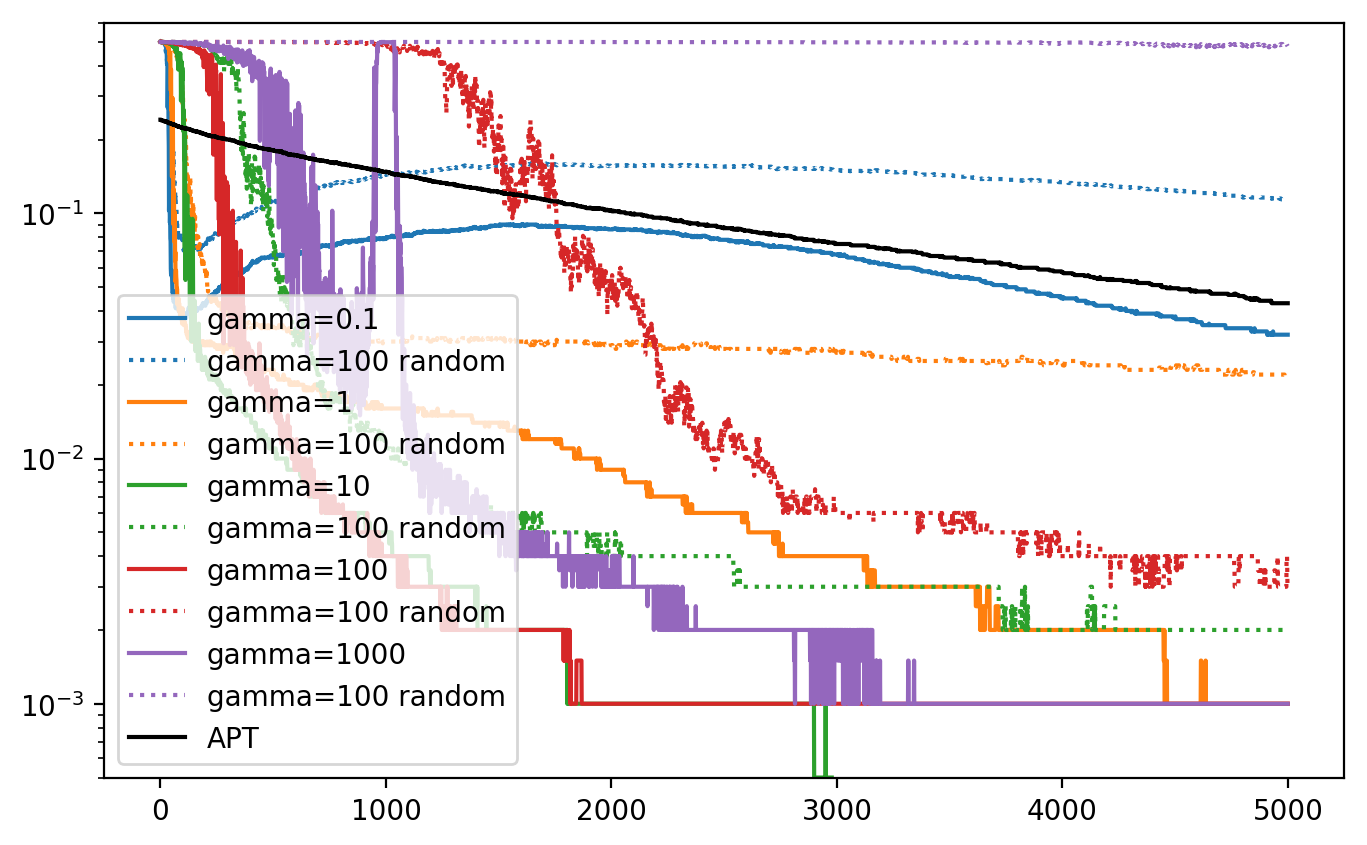

In [11]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 5), dpi=200)
for i in [gammas.index(g) for g in [0.1, 1, 10, 100, 1000]]:
    y = np.median(res3_np[:, i, 0, :], 0)
    y_1q = np.percentile(res3_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res3_np[:, i, 0, :], 75, 0)
    #plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.semilogy(y, c=colors[i], label='gamma=%g' % gammas[i])
    y = np.median(res3_rand_np[:, i, 0, :], 0)
    y_1q = np.percentile(res3_rand_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res3_rand_np[:, i, 0, :], 75, 0)
    #plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, ':', c=colors[i], label='gamma=100 random')
y = np.median(res3_np[:, 0, 1, :], 0)
y_1q = np.percentile(res3_np[:, 0, 1, :], 25, 0)
y_3q = np.percentile(res3_np[:, 0, 1, :], 75, 0)
#plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='black', alpha=0.4)
plt.plot(y, c='black', label='APT')
plt.legend()
plt.ylim(0, 0.6)
plt.show()

In [12]:
np.savez('sbm_binary.npz', res3_np=res3_np, res3_rand_np=res3_rand_np)

In [13]:
n = 10**3
sigma = 2
T = 5000
gammas = [0.1, 1, 10, 100, 1000]
tau = 0
epsilon = 1e-2
alpha = 1

n_trials = 100

res4 = GridParallel(n_jobs=7, verbose=1)(run_sbm_binary, n_trials*[n], [sigma], [T], gammas, [tau], [epsilon], [alpha], [False])
res4_np = np.squeeze(res4)
res4_rand = GridParallel(n_jobs=7, verbose=1)(run_sbm_binary_random_laplacian, n_trials*[n], [sigma], [T], gammas, [tau], [epsilon], [alpha], [False])
res4_rand_np = np.squeeze(res4_rand)

Number of tasks: 500.


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  5.3min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 12.4min


Number of tasks: 500.


[Parallel(n_jobs=7)]: Done 500 out of 500 | elapsed: 14.1min finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   58.5s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  5.0min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 11.7min
[Parallel(n_jobs=7)]: Done 500 out of 500 | elapsed: 13.4min finished


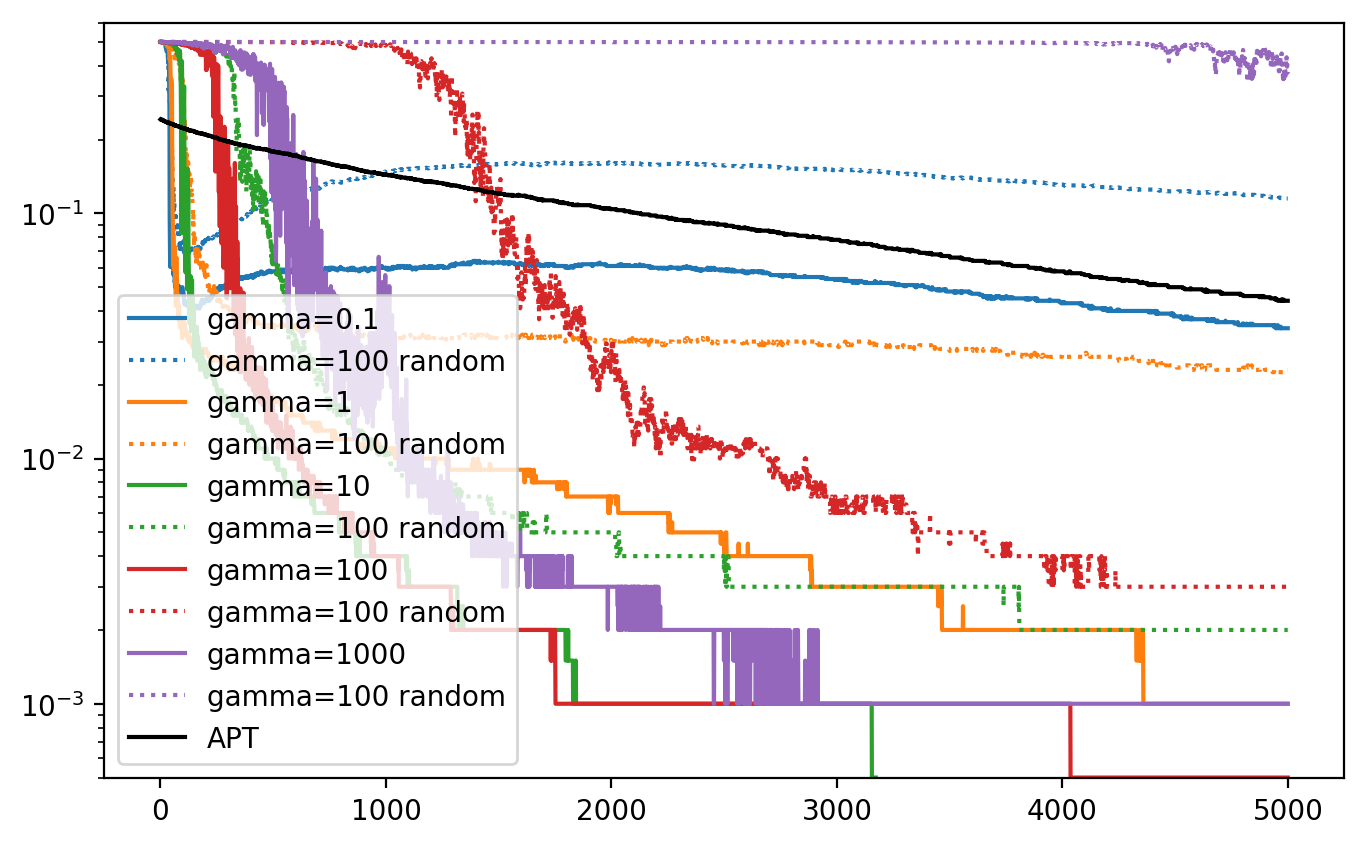

In [14]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 5), dpi=200)
for i in [gammas.index(g) for g in [0.1, 1, 10, 100, 1000]]:
    y = np.median(res4_np[:, i, 0, :], 0)
    y_1q = np.percentile(res4_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res4_np[:, i, 0, :], 75, 0)
    #plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.semilogy(y, c=colors[i], label='gamma=%g' % gammas[i])
    y = np.median(res4_rand_np[:, i, 0, :], 0)
    y_1q = np.percentile(res4_rand_np[:, i, 0, :], 25, 0)
    y_3q = np.percentile(res4_rand_np[:, i, 0, :], 75, 0)
    #plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.plot(y, ':', c=colors[i], label='gamma=100 random')
y = np.median(res4_np[:, 0, 1, :], 0)
y_1q = np.percentile(res4_np[:, 0, 1, :], 25, 0)
y_3q = np.percentile(res4_np[:, 0, 1, :], 75, 0)
#plt.fill_between(np.arange(T), y_1q, y_3q, facecolor='black', alpha=0.4)
plt.plot(y, c='black', label='APT')
plt.legend()
plt.ylim(0, 0.6)
plt.show()

In [15]:
np.savez('sbm_binary_alpha_1.npz', res4_np=res4_np, res4_rand_np=res4_rand_np)